Predicting student's performance based on features

In [4]:
!pip install catboost
!pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.1 MB/s eta 0:00:00


In [5]:
df = pd.read_csv("/content/StudentsPerformance.csv")
print(df.head())
df.shape

   gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75  


(1000, 8)

In [8]:
# check for missing values
print(df.isnull().sum())

# check for duplicates
print(df.duplicated().sum())

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64
0


Parent's education is one of the measures of academic performance

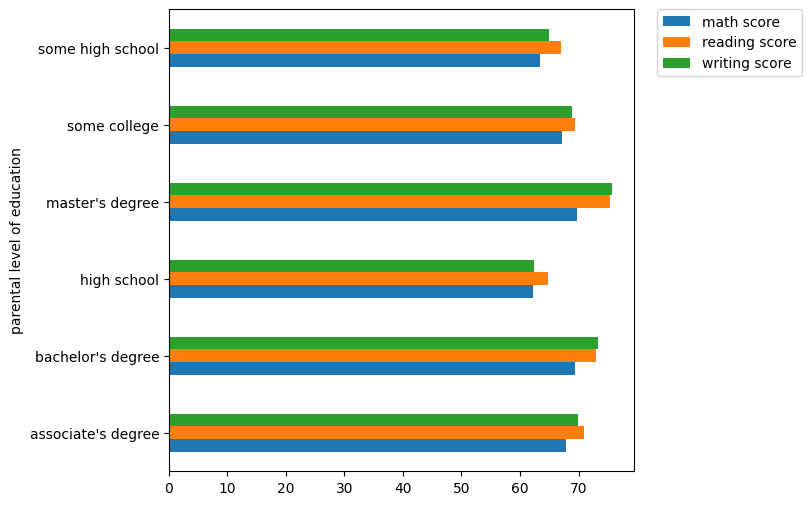

In [9]:
df.groupby('parental level of education')[['math score', 'reading score', 'writing score']].agg('mean').plot(kind='barh',figsize=(6, 6))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [10]:
X = df.drop(columns="math score",axis=1)
y = df["math score"]

num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer( [ ("OneHotEncoder", oh_transformer, cat_features), ("StandardScaler", numeric_transformer, num_features), ] )
X = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape


def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, mse, rmse, r2_square


models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBRegressor": XGBRegressor(),
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate Train and Test dataset
    model_train_mae, model_train_mse, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_mse, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)


    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Squared Error: {:.4f}".format(model_train_mse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))

    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    print('='*35)
    print('\n')



Linear Regression
Model performance for Training set
- Root Mean Squared Error: 5.3271
- Mean Squared Error: 28.3779
- Mean Absolute Error: 4.2694
- R2 Score: 0.8741
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.4186
- Mean Squared Error: 5.4186
- Mean Absolute Error: 4.2195
- R2 Score: 0.8793


Lasso
Model performance for Training set
- Root Mean Squared Error: 6.5938
- Mean Squared Error: 43.4784
- Mean Absolute Error: 5.2063
- R2 Score: 0.8071
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6.5197
- Mean Squared Error: 6.5197
- Mean Absolute Error: 5.1579
- R2 Score: 0.8253


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 5.7015
- Mean Squared Error: 32.5070
- Mean Absolute Error: 4.5070
- R2 Score: 0.8558
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 7.2802
- Mean Squared Error: 7.2802
- Mean Absolute Error

In [11]:
# Define hyperparameter ranges for each model
param_grid = {
    "Linear Regression": {},
    "Lasso": {"alpha": [1]},
    "K-Neighbors Regressor": {"n_neighbors": [3, 5, 7],},
    "Decision Tree": {"max_depth": [3, 5, 7],'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson']},
    "Random Forest Regressor": {'n_estimators': [8,16,32,64,128,256], "max_depth": [3, 5, 7]},
    "Gradient Boosting": {'learning_rate':[.1,.01,.05,.001],'subsample':[0.6,0.7,0.75,0.8,0.85,0.9], 'n_estimators': [8,16,32,64,128,256]},
    "XGBRegressor": {'depth': [6,8,10],'learning_rate': [0.01, 0.05, 0.1],'iterations': [30, 50, 100]},
    "CatBoosting Regressor": {"iterations": [100, 500], "depth": [3, 5, 7]},
    "AdaBoost Regressor": {'learning_rate':[.1,.01,0.5,.001],'n_estimators': [8,16,32,64,128,256]}
}

model_list = []
r2_list =[]

for model_name, model in models.items():
    # Create a scorer object to use in grid search
    scorer = make_scorer(r2_score)

    # Perform grid search to find the best hyperparameters
    grid_search = GridSearchCV(
        model,
        param_grid[model_name],
        scoring=scorer,
        cv=5,
        n_jobs=-1
    )

    # Train the model with the best hyperparameters
    grid_search.fit(X_train, y_train)
    y_train_pred = grid_search.predict(X_train)
    y_test_pred = grid_search.predict(X_test) # Evaluate Train and Test dataset
    model_train_mae, model_train_mse, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_mse, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    print(model_name)
    model_list.append(model_name)
    print('Best hyperparameters:', grid_search.best_params_)
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Squared Error: {:.4f}".format(model_train_mse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))
    print('----------------------------------')
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    print('='*35)
    print('\n')


Linear Regression
Best hyperparameters: {}
Model performance for Training set
- Root Mean Squared Error: 5.3271
- Mean Squared Error: 28.3779
- Mean Absolute Error: 4.2694
- R2 Score: 0.8741
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.4186
- Mean Squared Error: 5.4186
- Mean Absolute Error: 4.2195
- R2 Score: 0.8793


Lasso
Best hyperparameters: {'alpha': 1}
Model performance for Training set
- Root Mean Squared Error: 6.5938
- Mean Squared Error: 43.4784
- Mean Absolute Error: 5.2063
- R2 Score: 0.8071
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6.5197
- Mean Squared Error: 6.5197
- Mean Absolute Error: 5.1579
- R2 Score: 0.8253


K-Neighbors Regressor
Best hyperparameters: {'n_neighbors': 7}
Model performance for Training set
- Root Mean Squared Error: 5.9040
- Mean Squared Error: 34.8569
- Mean Absolute Error: 4.7066
- R2 Score: 0.8454
----------------------------------
Model performa

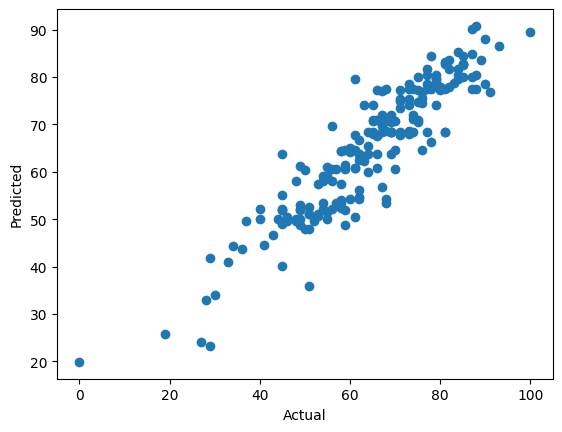

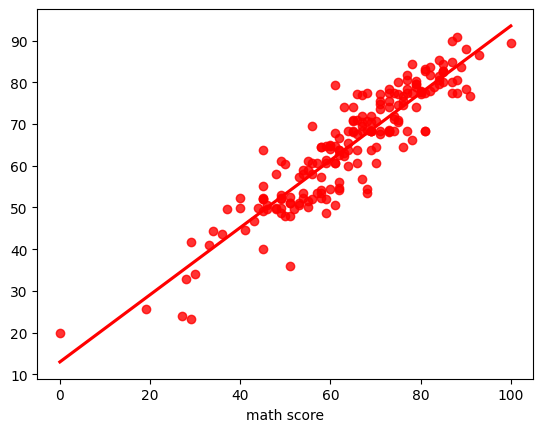

,Actual Value,Predicted Value,Difference
521,91,76.785425,14.214575
737,53,57.395349,-4.395349
740,80,77.631579,2.368421
660,74,77.463918,-3.463918
411,84,81.611650,2.388350
...,...,...,...
408,52,49.547009,2.452991
332,62,56.132743,5.867257
208,74,68.333333,5.666667
613,65,68.333333,-3.333333


In [13]:
y_pred = model.predict(X_test)
plt.scatter(y_test,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red')
plt.show()
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df